# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib4'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-fullCyc2_lib4.assembled.dmult.fastq')

# number of processors
nprocs = 10

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib4/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib4/pear_merged-fullCyc2_lib4.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-fullCyc2_lib4.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 5249241
Number of sequences post-filter: 5234000

>MR.M.13C-Xyl.D6.R1_Frac19_0 orig_name=M01032:446:000000000-AW1G6:1:1101:15700:1735
TACGTAGGGGTCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCTCGTAGGCGGTTTCGTAAGTCAGGGGTGAAATCCC
GGGGCTCAACCTCGGAACTGCCTTTGATACTGCCGGTCTTGAGTCCGATAGAGGTGGGTGGAATTCCTAGTGTAGAGGTG
AAATTCGTAGATATTAGGAAGAACACCGGTGGCGAAGGCGGCCCACTGGAACGGTACTGACGCTGAGGTGCGAAAGCGTG
GGGAGCAAACAGG
>MR.A.13C-Ami.D3.R1_Frac6_1 orig_name=M01032:446:000000000-AW1G6:1:1101:15156:1741
TACGTAGGGTGCGAGCGTTATTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTTCGGTAAGTCAGATGTGAAATCCC
CGGGCTTAACCTGGGAACTGCATTTGTGACTGGCGGGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 5234000
Number of sequences post-filter: 5234000


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.M.13C-Xyl.D6.R1_Frac19_0	MR.M.13C-Xyl.D6.R1_Frac19
MR.A.13C-Ami.D3.R1_Frac6_1	MR.A.13C-Ami.D3.R1_Frac6
MR.F.13C-Cel.D14.R2_Frac28_3	MR.F.13C-Cel.D14.R2_Frac28
MR.M.13C-Xyl.D6.R1_Frac13_4	MR.M.13C-Xyl.D6.R1_Frac13
MR.A.13C-Ami.D3.R1_Frac24_5	MR.A.13C-Ami.D3.R1_Frac24
MR.A.13C-Ami.D3.R1_Frac9_6	MR.A.13C-Ami.D3.R1_Frac9
MR.A.13C-Ami.D3.R1_Frac9_7	MR.A.13C-Ami.D3.R1_Frac9
MR.F.12C-Con.D14.R1_Frac27_9	MR.F.12C-Con.D14.R1_Frac27
MR.M.13C-Xyl.D6.R1_Frac9_8	MR.M.13C-Xyl.D6.R1_Frac9
MR.M.13C-Xyl.D6.R1_Frac16_10	MR.M.13C-Xyl.D6.R1_Frac16


In [13]:
! head -n 200 group_file.txt

MR.M.13C-Xyl.D6.R1_Frac19_0	MR.M.13C-Xyl.D6.R1_Frac19
MR.A.13C-Ami.D3.R1_Frac6_1	MR.A.13C-Ami.D3.R1_Frac6
MR.F.13C-Cel.D14.R2_Frac28_3	MR.F.13C-Cel.D14.R2_Frac28
MR.M.13C-Xyl.D6.R1_Frac13_4	MR.M.13C-Xyl.D6.R1_Frac13
MR.A.13C-Ami.D3.R1_Frac24_5	MR.A.13C-Ami.D3.R1_Frac24
MR.A.13C-Ami.D3.R1_Frac9_6	MR.A.13C-Ami.D3.R1_Frac9
MR.A.13C-Ami.D3.R1_Frac9_7	MR.A.13C-Ami.D3.R1_Frac9
MR.F.12C-Con.D14.R1_Frac27_9	MR.F.12C-Con.D14.R1_Frac27
MR.M.13C-Xyl.D6.R1_Frac9_8	MR.M.13C-Xyl.D6.R1_Frac9
MR.M.13C-Xyl.D6.R1_Frac16_10	MR.M.13C-Xyl.D6.R1_Frac16
MR.F.12C-Con.D14.R1_Frac27_11	MR.F.12C-Con.D14.R1_Frac27
MR.A.13C-Ami.D3.R1_Frac9_12	MR.A.13C-Ami.D3.R1_Frac9
MR.F.12C-Con.D14.R1_Frac27_14	MR.F.12C-Con.D14.R1_Frac27
MR.M.13C-Van.D30.R1_Frac18_13	MR.M.13C-Van.D30.R1_Frac18
MR.M.13C-Van.D30.R1_Frac17_16	MR.M.13C-Van.D30.R1_Frac17
MR.M.13C-Van.D30.R1_Frac14_17	MR.M.13C-Van.D30.R1_Frac14
MR.F.13C-Xyl.D14.R3_Frac8_18	MR.F.13C-Xyl.D14.R3_Frac8
MR.F.13C-Pal.D30.R2_Frac10_19	MR.F.13C-Pal.D30.R2_Frac10
MR.M.13C-Van.

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

5212000	2138699
5213000	2139046
5214000	2139396
5215000	2139776
5216000	2140128
5217000	2140463
5218000	2140780
5219000	2141092
5220000	2141440
5221000	2141778
5222000	2142144
5223000	2142503
5224000	2142865
5225000	2143222
5226000	2143589
5227000	2143999
5228000	2144400
5229000	2144796
5230000	2145256
5231000	2145688
5232000	2146128
5233000	2146571
5234000	2147007

Output File Names: 
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.names
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 2147007


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 241M May 15 20:04 pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-15 20:04:18--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0%  190M 0s
    50K .......... .......... .......... .......... ..........  0% 1.16M 8s
   100K .......... .......... .......... .......... ..........  0% 1.70M 9s
   150K .......... .......... .......... .......... ..........  1%  993K 11s
   200K .......... .......... .......... .......... ..........  1% 1.86M 11s
   250K .......... .......... .......... .......... ..........  1% 1002K 12s
   300K .......... .......... .......... .......... ..........  1% 1.90M 12s
   350K .......... .......... .......... .......... ..........  2%  986K 13s
   400K .......... .......... ..........

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

700
800
900
1000
1100
1118



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [19]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors={}, flip=T)"'.format(qcFile3a, silvaFileFilt, nprocs)
!$cmd | tail -n 30

214600
214700
214800
214900
215000
215100
215200
215300
215400
215433
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 1276 secs to align 2147007 sequences.


Output File Names: 
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.align
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>

In [20]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 21G May 15 20:26 pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.align


In [21]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

213300
213400
213500
213600
213700
213800
213900
214000
214100
214200
214300
214400
214500
214600
214700
214723



Length of filtered alignment: 1572
Number of columns removed: 8608
Length of the original alignment: 10180
Number of sequences used to construct filter: 2147007

Output File Names: 
pear_merged-fullCyc2_lib4.filter
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [22]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 3.3G May 15 20:28 pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.fasta


In [23]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	450	1198	253	0	4	130851
25%-tile:	450	1198	253	0	4	1308501
Median: 	450	1198	253	0	5	2617001
75%-tile:	450	1198	253	0	6	3925501
97.5%-tile:	450	1198	254	0	8	5103151
Maximum:	1572	1572	399	0	234	5234000
Mean:	451.45	1197.96	252.423	0	5.08109
# of unique seqs:	2147007
total # of seqs:	5234000

Output File Names: 
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.summary

It took 25 secs to summarize 5234000 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [27]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 450, 1198)
!$cmd | tail -n 30

Processing sequence: 213100
Processing sequence: 213200
Processing sequence: 213300
Processing sequence: 213400
Processing sequence: 213500
Processing sequence: 213600
Processing sequence: 213700
Processing sequence: 213800
Processing sequence: 213900
Processing sequence: 214000
Processing sequence: 214100
Processing sequence: 214200
Processing sequence: 214300
Processing sequence: 214400
Processing sequence: 214500
Processing sequence: 214600
Processing sequence: 214700
Processing sequence: 214800
Processing sequence: 214841

Output File Names: 
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 35 secs to screen 2147007 sequences.

mothur > quit()


In [28]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 2108919


In [29]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

210600
210700
210800
210900
211000
211030



Length of filtered alignment: 1039
Number of columns removed: 533
Length of the original alignment: 1572
Number of sequences used to construct filter: 2108919

Output File Names: 
pear_merged-fullCyc2_lib4.filter
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [30]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 2.2G May 15 20:36 pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [31]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-fullCyc2_lib4.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [32]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [33]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 10 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	202	202	0	3	1
2.5%-tile:	1	253	253	0	4	128939
25%-tile:	1	253	253	0	4	1289387
Median: 	1	253	253	0	5	2578773
75%-tile:	1	253	253	0	6	3868159
97.5%-tile:	1	254	254	0	8	5028607
Maximum:	1	399	399	0	8	5157545
Mean:	1	252.922	252.922	0	5.07454
# of Seqs:	5157545

Output File Names: 
finalQC.summary

It took 6 secs to summarize 5157545 sequences.

mothur > quit()


In [34]:
!head -n 6 $qcFinal

>MR.M.13C-Xyl.D6.R1_Frac19_0
TACGTAGGGGTCTAGCGTTGTTCGGAATCACTGGGCGTAAAGCGCTCGTAGGCGGTTTCGTAAGTCAGGGGTGAAATCCCGGGGCTCAACCTCGGAACTGCCTTTGATACTGCCGGTCTTGAGTCCGATAGAGGTGGGTGGAATTCCTAGTGTAGAGGTGAAATTCGTAGATATTAGGAAGAACACCGGTGGCGAAGGCGGCCCACTGGAACGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
>MR.A.13C-Ami.D3.R1_Frac6_1
TACGTAGGGTGCGAGCGTTATTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTTCGGTAAGTCAGATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATTTGTGACTGGCGGGCTAGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTGATGCACGAAAGCGTGGGGAGCAAACCGG
>MR.F.13C-Cel.D14.R2_Frac28_3
TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTGATGTAAGACCGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTGGTGACTGCATTGCTTGAGTATGGCAGAGGGGGGTAGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAATACCGATGGCGAAGGCAGCCCCCTGGGCCAATACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGG


## Summary of number of seqs per sample

In [35]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [36]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.M.13C-Xyl.D6.R1_Frac19,29315
1,MR.A.13C-Ami.D3.R1_Frac6,78634
2,MR.F.13C-Cel.D14.R2_Frac28,36723
3,MR.F.13C-Cel.D14.R2_Frac23,26141
4,MR.F.13C-Xyl.D14.R3_Frac8,27362
5,MR.F.13C-Xyl.D14.R3_Frac16,18413
6,MR.F.13C-Xyl.D14.R3_Frac22,17506
7,MR.F.13C-Xyl.D14.R3_Frac12,62853
8,MR.F.12C-Con.D14.R1_Frac19,69025
9,MR.F.13C-Pal.D30.R2_Frac8,9095


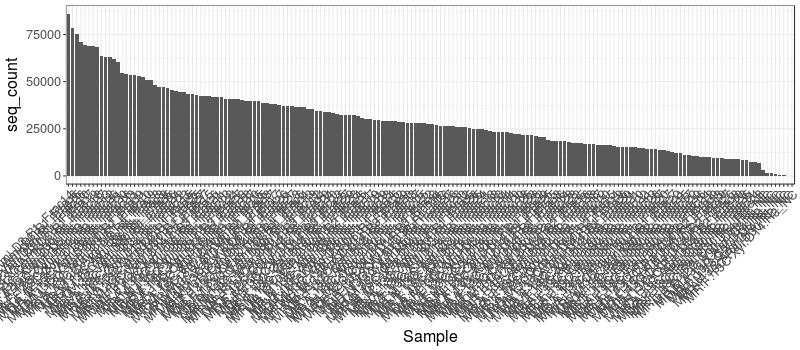

In [37]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [39]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                        Sample seq_count rank
156 MR.F.13C-Pal.D30.R2_Frac12      9899   21
157  MR.F.13C-Pal.D30.R2_Frac9      9692   20
158 MR.A.13C-Ami.D14.R1_Frac18      9595   19
159 MR.F.13C-Pal.D30.R2_Frac19      9448   18
160  MR.F.13C-Pal.D30.R2_Frac7      9114   17
161 MR.A.13C-Ami.D14.R1_Frac26      9108   16
162  MR.F.13C-Pal.D30.R2_Frac8      9095   15
163 MR.A.13C-Ami.D14.R1_Frac10      8906   14
164 MR.A.13C-Ami.D14.R1_Frac23      8560   13
165 MR.F.13C-Pal.D30.R2_Frac25      8227   12
166 MR.F.13C-Pal.D30.R2_Frac11      7182   11
167 MR.F.13C-Pal.D30.R2_Frac24      7152   10
168 MR.F.13C-Pal.D30.R2_Frac23      6665    9
169     MR.F.12C-Con.D14.R1_NC      3206    8
170     MR.M.13C-Van.D30.R1_NC      1666    7
171      MR.A.13C-Ami.D3.R1_NC      1514    6
172     MR.F.13C-Cel.D14.R2_NC      1097    5
173      MR.M.13C-Xyl.D6.R1_NC       549    4
174     MR.A.13C-Ami.D14.R1_NC       445    3
175     MR.F.13C-Pal.D30.R2_NC       225    2
176     MR.F.13C-Xyl.D14.R3_NC    